# Time Series Analysis of My Solar Panels

## Introduction

Almost ten years ago, we had solar panels installed on our rooftop home in Coolum (Australian sea-side town in the sub-tropics).  The system we have includes an inverter is prepared to talk via Bluetooth to your own apps, providing information on power generated, internal temperature, etc.  In that time we have replaced the roof under the panels - one of the downsides of being two streets from the beach is that the salt spray corrodes everything eventually.

I have been running a cheap dedicated Android tablet, running an app [Oxley Solar Pro](https://play.google.com/store/apps/details?id=au.com.oxleyws.solar.pro&hl=en_AU&gl=US), that provides a display inside our home of how the power generation is going.  In fact, I am onto my second tablet, as the first one had its battery swell up after five years or so.  In its own words:

>Oxley Solar Pro is an easy to use and fast Android app for monitoring and logging your photovoltaic systems.

As well as communication with the solar panels inverter, the Oxley Solar Pro app also can be configured to upload the solar data to [PVOutput](https://pvoutput.org).
In its own words:
> PVOutput is a free service for sharing and comparing PV output data.

I have nothing but high praise for both Oxley Solar Pro, and PVOutput.org, as both systems have just worked for the aomost ten years I have been using them.

## The problem

One of the issues associated with solar panels is that they are reputed to besome less efficient with time.  I was interested to see if I could detect any long-term changes in my system.

It is possible to download your own data from PVOutput.org, so I performed a download of daily energy generation, into a set of CSV files (one for each 365 day period)

## The analysis approach
 I initially decided to treat the daily solar energy as a time series, and use the ```statsmodels``` time series utilities to break out seasonal affects, and long term trends.

------------

## Implementation

### Environment
Import the Python packages we will use.  As well as time series analysis, I am going to some OLS regression.

```pathlib``` is for easy handling of file paths.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.formula.api import ols

import pathlib

Load the supporting libraries

In [62]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [63]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Data load

We define the drectory holding the data files

In [64]:
data_dir = pathlib.Path('../data/SolarDaily')

file1 = 'PVOutput-COOLUMSUNSPOT-2013.csv'

data_path = data_dir / file1

Read the CSV data, skipping over row 0 (first row) as a header, and only using the first two columns, that first of which contains a date.  Not being a monster, of course the day number comes first  (as opposed to MM/DD/YYYY)

In [65]:
df = pd.read_csv(
    data_path,
    header=0,
    usecols=[0, 1],
    parse_dates={'Date': [0]},
    dayfirst=True,
)

### Data exploration

Peek at the data file.  Note data is in reverse chronical order (as given to us from PVOutput.org)

In [66]:
df.head()

,Date,GENERATED
0,2014-12-08,18353
1,2014-12-07,28872
2,2014-12-06,11319
3,2014-12-05,25261
4,2014-12-04,30741


Check the data types  (seems OK), and the date-time values in column 0 (first column)

In [67]:
df.dtypes

Date         datetime64[ns]
GENERATED             int64
dtype: object

In [68]:
df.iloc[0, 0]

Timestamp('2014-12-08 00:00:00')

<AxesSubplot:xlabel='Date'>

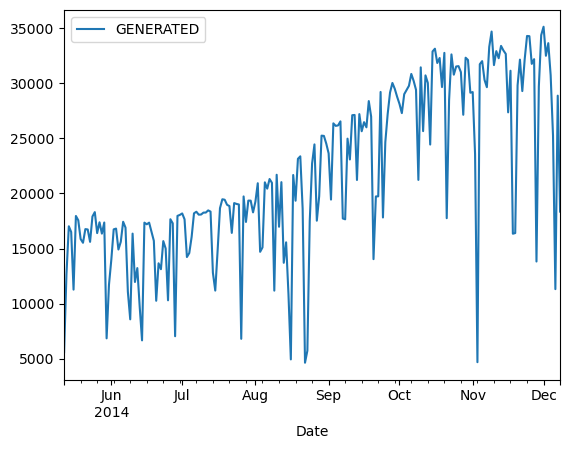

In [69]:
df.plot('Date', 'GENERATED')

### Full data load

We define some helper functions to load the yearly files

In [70]:
def read_year_file(year: int):
    '''
    read_year_file: read the solar panel data in CSV format for the given year

    We construct a file name from the supplied year value and read the CSV data,
    skipping over row 0 (first row) as a header,
    and only using the first two columns, that first of which contains a date.
    The day number comes first (i.e. DD/MM/YYY, as opposed to MM/DD/YYYY)

    Parameters:
    year: int - the notional year of the data set to be loaded
    note - each 365 day data set spans two years, due the the way data download was
    done from the PVOutput website

    Returns:
    pandas dataframe

    Limitations:
    Does not check for file actually existing

    Does not check for successful pandas CSV read
    '''
    data_dir = pathlib.Path('../data/SolarDaily')
    file1 = 'PVOutput-COOLUMSUNSPOT-' + str(year) + '.csv'
    data_path = data_dir / file1

    df = pd.read_csv(
        data_path,
        header=0,
        usecols=[0, 1],
        parse_dates={'Date': [0]},
        dayfirst=True,
    )
    return df


# end read_year_file


def plot_year_file(year: int, ax) -> None:
    '''
    plot_year_file: read a solar panel daily energy data file, and plot results

    Parameters:
    year: int - year of the 365 day data set
    ax: Matplotlib Axes object

    Limitations:
    uses pandas plotting functions, could be prettier

    '''

    df = read_year_file(year)
    df.plot(
        'Date',
        'GENERATED',
        ax=ax,
    )


# end plot_year

### Initial data plot

We load and plot the solar panel data for the each year we have data.  We make a grid (5 rows by 2 columns), and plot each year within this grid.

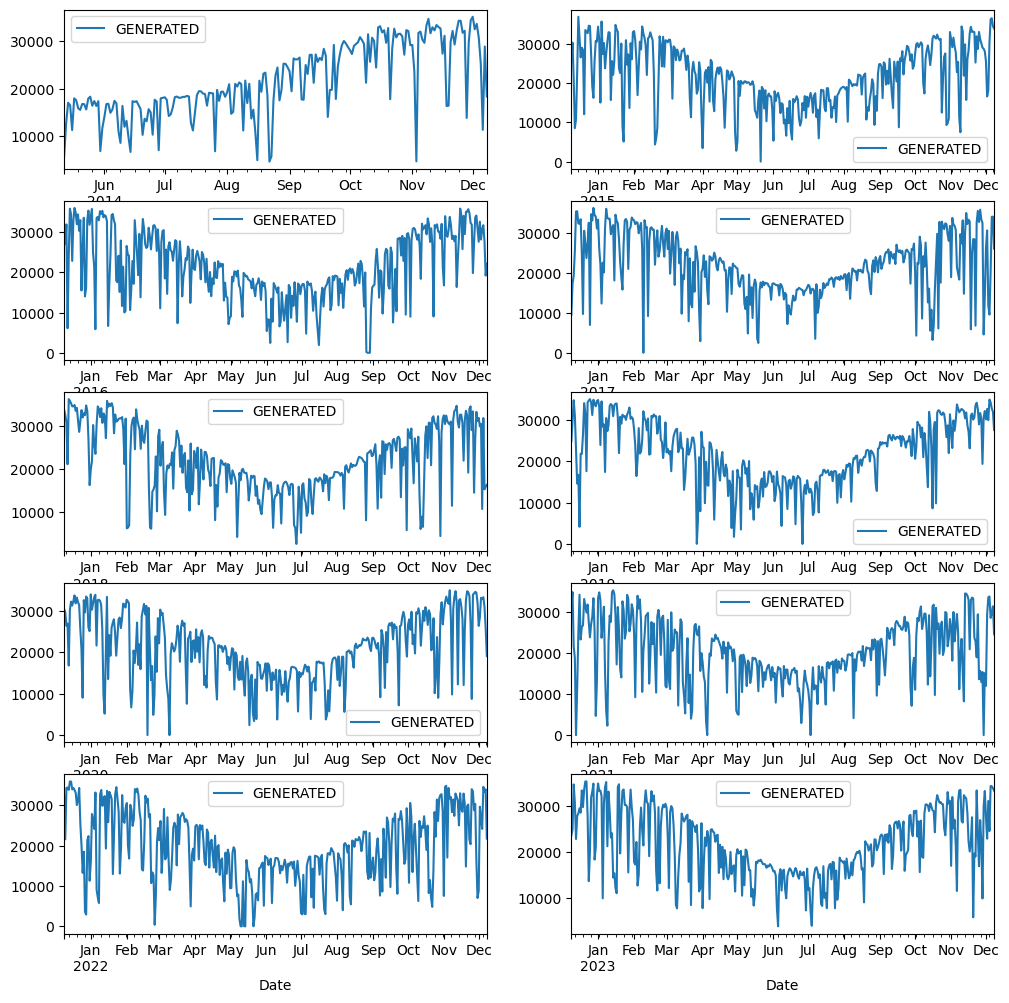

In [71]:
fig, axes = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=(12, 12),
)

for y, ax in zip(
    list(range(2014, 2024, 1)), axes.flatten()
):
    plot_year_file(y, ax)
# end for

For a different view, we plot all years on the same plot (but with a unique color).

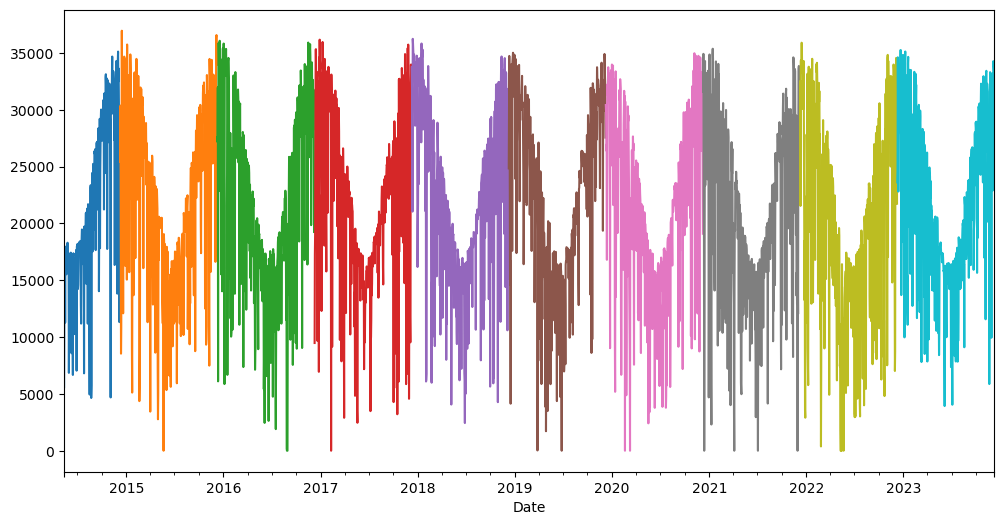

In [72]:
fig, ax = plt.subplots(
    figsize=(12, 6),
)

for y in list(range(2014, 2024, 1)):

    plot_year_file(y, ax)
# end for
ax.get_legend().set_visible(False)

## Data transformation

From the plots above, it is apparent that the natural variability of the weather makes spotting any long term trends very  hard.  We take one years worth of data, and experiment with different data transformations.

In [73]:
df = read_year_file(2023)

In [74]:
df.head()

,Date,GENERATED
0,2023-12-08,33279
1,2023-12-07,33808
2,2023-12-06,34220
3,2023-12-05,34286
4,2023-12-04,24544


Sort dates in ascending order

In [75]:
df.sort_values(
    'Date',
    inplace=True,
)

The first transformation is to sum solar output over each week, using the ```pandas``` resample function

In [76]:
week_df = df.resample(
    rule='W',
    on='Date',
).sum()

Peek at the dataframe (data points now 7 days apart), and plot the result.

In [77]:
week_df.head()

,GENERATED
Date,
2022-12-11,83085
2022-12-18,200958
2022-12-25,195198
2023-01-01,206205
2023-01-08,208193


<AxesSubplot:xlabel='Date'>

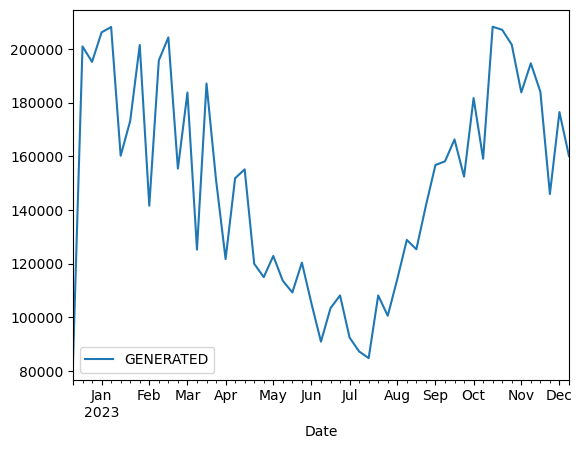

In [78]:
week_df.plot()

This is a little disappointing, in that we still have a lot of variation in the data.

The next (and final) transformation is based on the idea that in a week, there should be one day when we have no clouds.  So, instead of summing, we take the maximum daily value in each week.

The plot shows that we have what we want, being a reasonable estimate the peak power output within each week.

In [79]:
week_df = df.resample(
    rule='W',
    on='Date',
).max()

<AxesSubplot:xlabel='Date'>

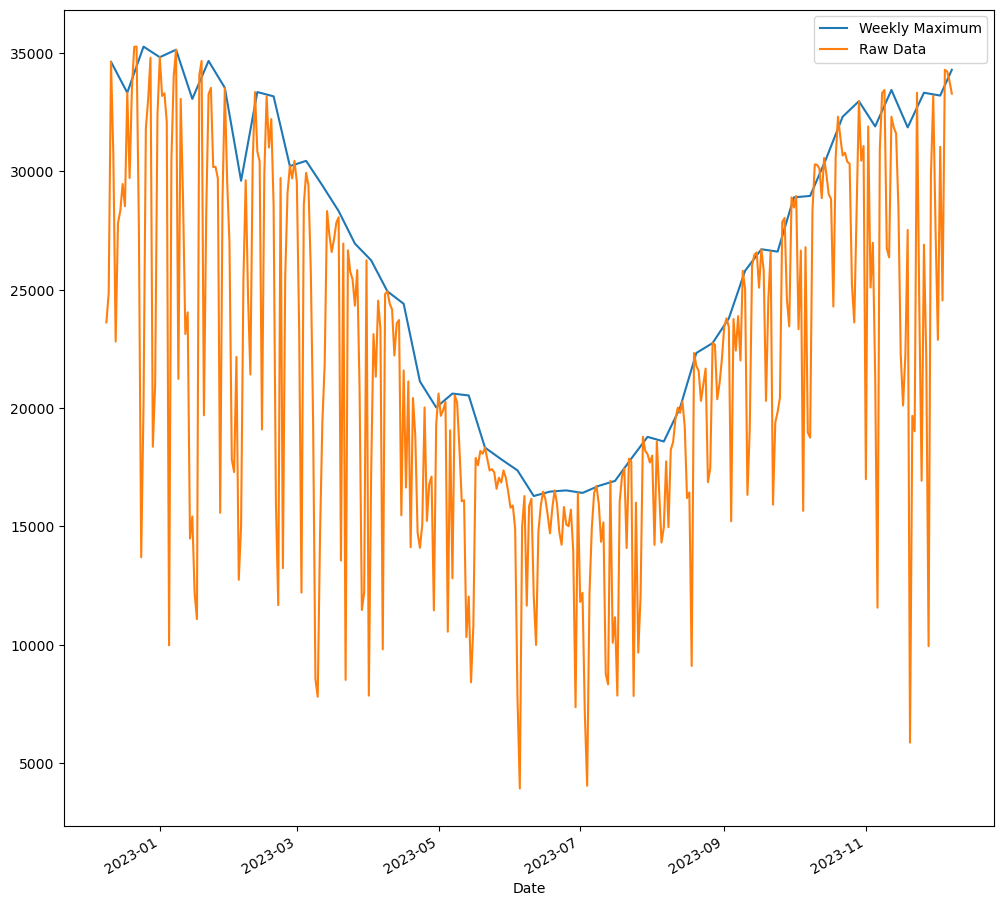

In [80]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 12),
)


week_df.plot(
    'Date',
    'GENERATED',
    ax=ax,
    label='Weekly Maximum',
)
df.plot('Date', 'GENERATED', ax=ax, label='Raw Data')

### Final data transformation

So now we read all the 365 day data files, concatenate them with ```pandas```, sort the date value into ascending order, and plot the result (as expected loads of variation)

<AxesSubplot:xlabel='Date'>

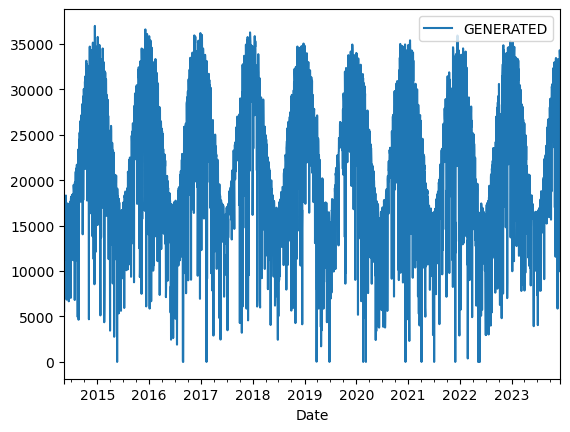

In [81]:
year_dfs = [
    read_year_file(year) for year in range(2014, 2024, 1)
]

df = pd.concat(year_dfs)
df.sort_values(
    'Date',
    inplace=True,
)
df.plot('Date', 'GENERATED')

We now resample over each week, taking the maximum solar output in that week.  The resulting plot is much smoother.  Effectively, we have thrown away the cloudy days that prevent maximum solar output (or so we hope)

<AxesSubplot:xlabel='Date'>

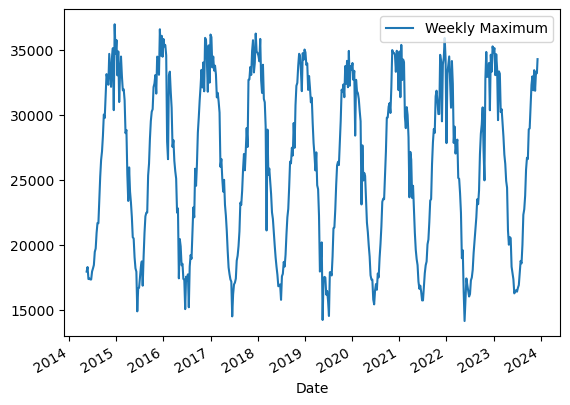

In [82]:
all_weeks_df = df.resample(
    rule='W',
    on='Date',
).max()

all_weeks_df.plot(
    'Date',
    'GENERATED',
    label='Weekly Maximum',
)

--------------
## Analysis

The model we adopt is that we assume a long-term trend (solar panel degradation), which multiplies the seasonal affects (more direct sunshine in summer).  We have 500 weeks worth of data.

In [83]:
all_weeks_df.shape

(500, 2)

In [84]:
tsa_df = seasonal_decompose(
    all_weeks_df['GENERATED'],
    model='mul',
)

Show the components of the model.  In the sense that the residiual errors in the multiplicative factor are clustered around 1, with no obvious errors, this seems a reasonable model.

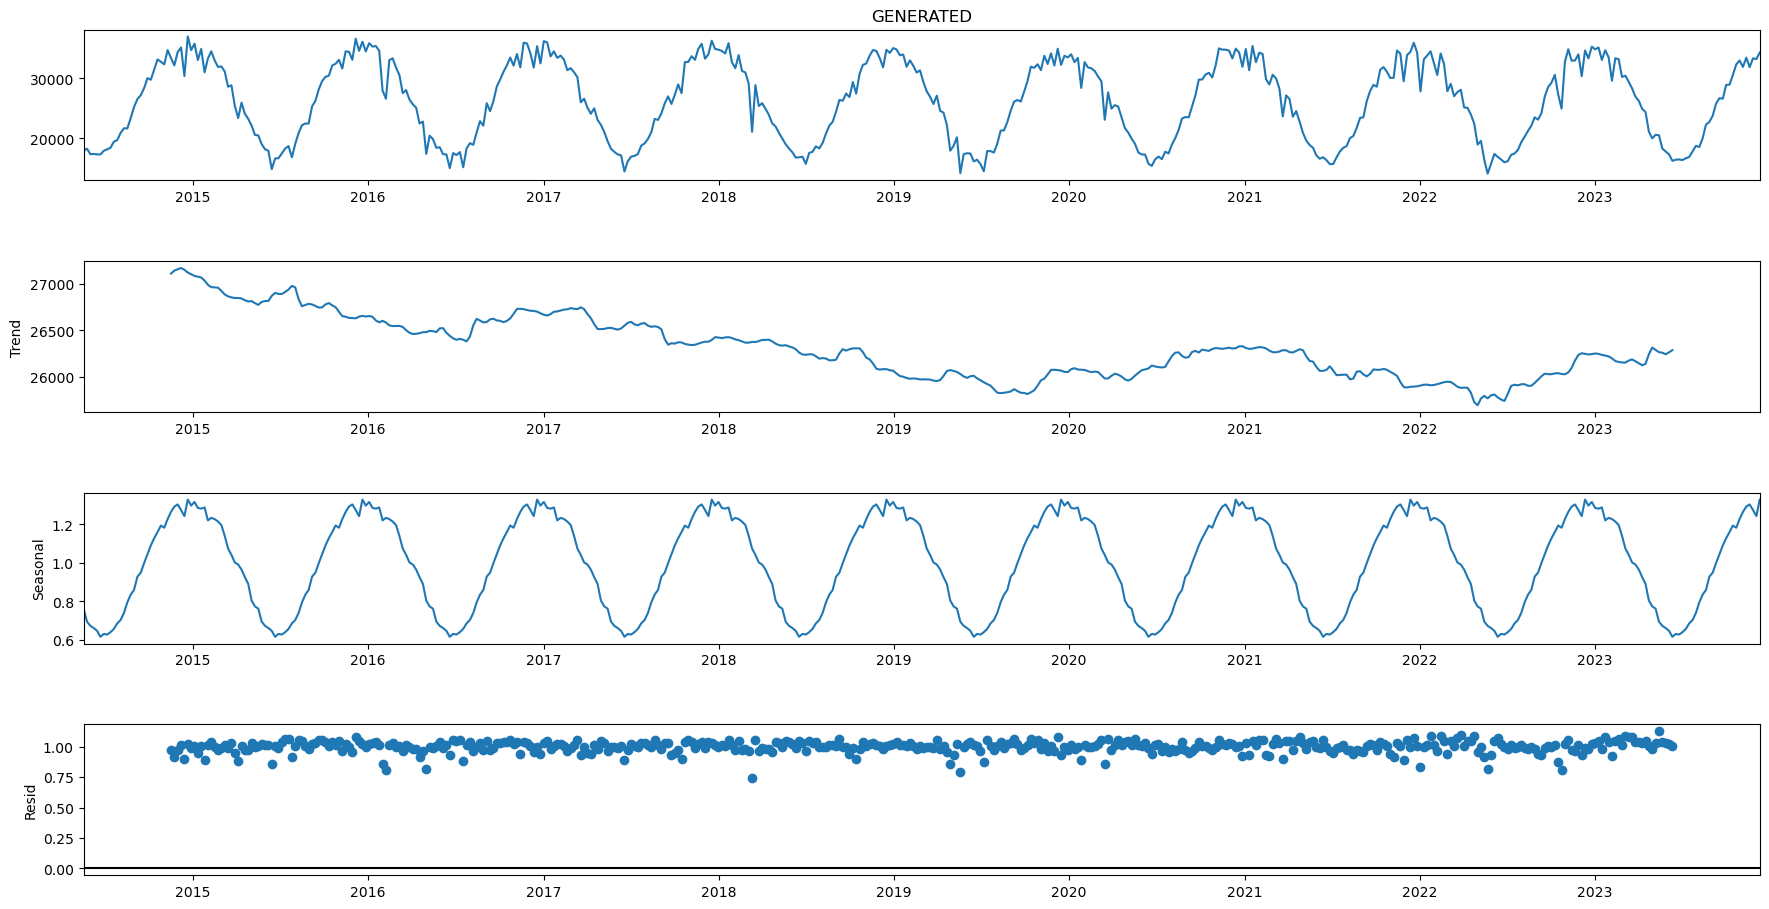

In [85]:
fig = tsa_df.plot()
fig.set_size_inches(20, 10)

We focus on the residual errors - seems satisfactory.

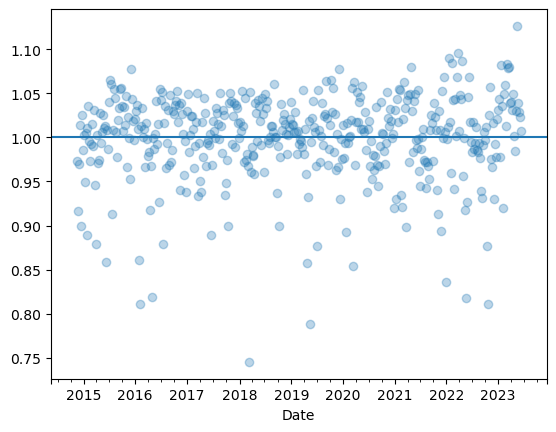

In [86]:
tsa_df.resid.plot(
    kind='line',
    linewidth=0,
    marker='o',
    alpha=0.3,
)
plt.axhline(1.0)

### Trend analysis

We now look at the trend line.  The trend line arrays returned by ```statsmodels``` begin and end with NaN values, that we must prune before we can do our OLS regression analysis.

In [87]:
tsa_df.trend.head()

Date
2014-05-18   NaN
2014-05-25   NaN
2014-06-01   NaN
2014-06-08   NaN
2014-06-15   NaN
Freq: W-SUN, Name: trend, dtype: float64

In [88]:
tsa_df.trend.dropna().head()

Date
2014-11-16    27112.519231
2014-11-23    27144.326923
2014-11-30    27159.605769
2014-12-07    27172.548077
2014-12-14    27153.971154
Freq: W-SUN, Name: trend, dtype: float64

We now address the problem that OLS regression needs numeric values, and can't handle regression with pandas TimeStamp objects as the exogenous variable.  We create a pandas DataFrame with a column of Julian Day values (which are numeric), and a column of weekly maximum generated energy values.

The Julian Day values will be quiet large as:
>0 Julian date is noon January 1, 4713 BC.

but we are only interested in the slope of the trend line, not the Y axis intercept.

In [89]:
tsa_df.trend.index

DatetimeIndex(['2014-05-18', '2014-05-25', '2014-06-01', '2014-06-08',
               '2014-06-15', '2014-06-22', '2014-06-29', '2014-07-06',
               '2014-07-13', '2014-07-20',
               ...
               '2023-10-08', '2023-10-15', '2023-10-22', '2023-10-29',
               '2023-11-05', '2023-11-12', '2023-11-19', '2023-11-26',
               '2023-12-03', '2023-12-10'],
              dtype='datetime64[ns]', name='Date', length=500, freq='W-SUN')

Create a helper DataFrame, and perform OLS regression, Julian Day as the independent variable, and Generated Energy as the dependent variable.

In [90]:
trend_df = pd.DataFrame(
    {
        'Julian_Day': tsa_df.trend.dropna().index.to_julian_date(),
        'GENERATE': tsa_df.trend.dropna().values,
    }
)

res = ols(
    'GENERATE ~ Julian_Day',
    data=trend_df,
).fit()

This tells me that every day, I lose an additional 0.3 (approximately) of a Watt Hour in energy generated during the day at peak solar (no clouds)

In [91]:
res.params[1:]

Julian_Day   -0.292253
dtype: float64

In [92]:
energy_reduction_yearly_wh = res.params[1:][0] * 365
energy_reduction_yearly = energy_loss_yearly_wh / 1000
print(
    f'Energy reduction on best day solar, one year to next = {energy_reduction_yearly:1.3f}KWh'
)

Energy reduction on best day solar, one year to next = -0.107KWh


As can be seen from the above calculation, the reduced efficiency is barely noticeable year-to-year, given that on a good summer day, I get over 30KWh of energy.

 #### Visualization
 
 Plot the line of best fit.

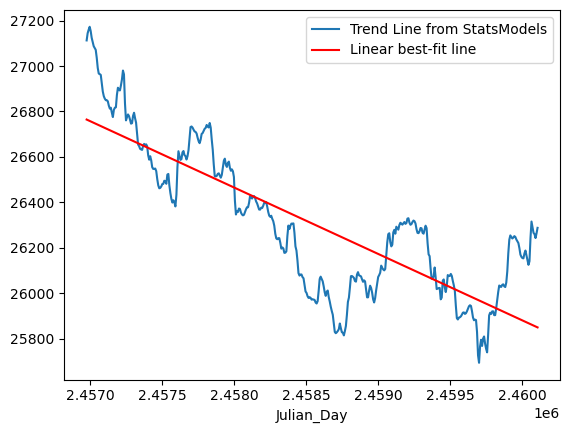

In [93]:
trend_df.plot(
    'Julian_Day',
    'GENERATE',
    label='Trend Line from StatsModels',
)
plt.plot(
    trend_df['Julian_Day'],
    res.predict(),
    'r-',
    label='Linear best-fit line',
)
plt.legend()

As expected, when we look at the auto-correlation of the seasonal array, we get peaks at 1,2,3 .. years (I have ignored leap years).

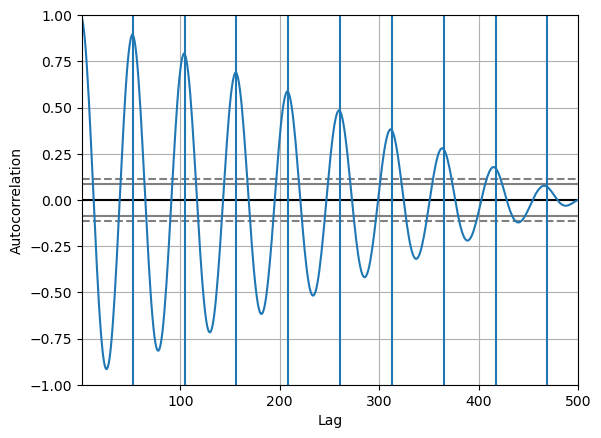

In [94]:
pd.plotting.autocorrelation_plot(
    tsa_df.seasonal.to_list(),
)
for y in range(1, 10):
    plt.axvline((365 / 7) * y)
# end for

-----------------
## Alternative model

There is an alternative analysis tool in the ```statsmodels``` toolbox, called STL, which will:

>decompose a time series into three components: trend, season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components.

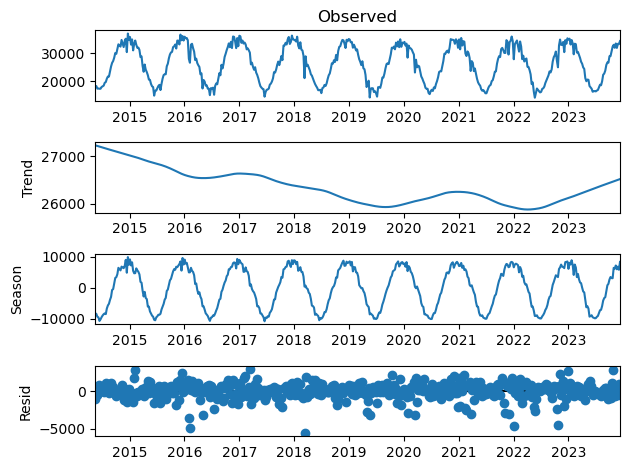

In [95]:
res = STL(all_weeks_df.drop(columns='Date')).fit()

res.plot()
plt.show()

Plotting the trend line from both tools shows they give essentially the same result.

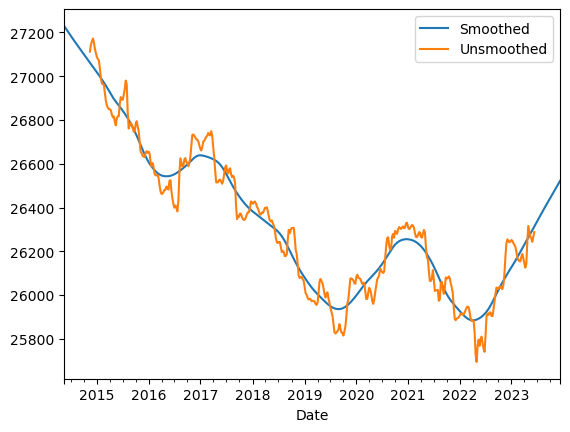

In [96]:
res.trend.plot(label='Smoothed')
tsa_df.trend.plot(label='Unsmoothed')
plt.legend()

-----------------
## Conclusions

Based upon the models used in this blog post, I am experencing a very mild reduction in efficiency in my solar panels, as time rolls on.

There might be other factors in play: for example, climate change might be putting more salt spray, or water vapour  in the air to block solar energy hitting the panels.

## Execution Environment

In [97]:
%watermark

Last updated: 2024-01-02T10:56:21.820469+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [98]:
%watermark -co -iv

conda environment: base

pandas     : 1.4.4
statsmodels: 0.13.2
matplotlib : 3.5.2
pathlib    : 1.0.1

